In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [4]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


## Data Preprocessing

In [5]:
df_train.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000
mean,94.480458,1990.876367,1.359443,103.840110,0.0,2590.328333
std,24.082642,12.141435,0.042505,0.071627,0.0,714.910468
min,34.000000,1966.000000,1.270380,103.685228,0.0,300.000000
25%,73.000000,1981.000000,1.330939,103.778803,0.0,2100.000000
50%,93.000000,1988.000000,1.354024,103.845301,0.0,2400.000000
75%,110.000000,2000.000000,1.386968,103.897418,0.0,3000.000000
max,215.000000,2019.000000,1.457071,103.964915,0.0,6950.000000


In [6]:
df_train.columns

Index(['rent_approval_date', 'town', 'block', 'street_name', 'flat_type',
       'flat_model', 'floor_area_sqm', 'furnished', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region', 'monthly_rent'],
      dtype='object')

In [208]:
def category_map(df_origin, df_train_):
    df = df_origin.copy()
    df_train_ = df_train_.copy()
    colums = ['town', 'street_name', 'flat_type', 'flat_type2', 'cluster', 'block',
              'lease_commence_date', 'flat_model', 'subzone', 'planning_area','region']
    #locations = ['town', 'block', 'street_name', 'subzone', 'planning_area','region', 'cluster']
    
    for col in colums:
        group_mean = df_train_.groupby(col)['monthly_rent'].mean()
        group_std = df_train_.groupby(col)['monthly_rent'].std()
        group_median = df_train_.groupby(col)['monthly_rent'].median()
        cat_map = group_mean.index
        mean_dict = {cat_map[i]:group_mean[cat_map[i]] for i in range(len(cat_map))}
        std_dict = {cat_map[i]:group_std[cat_map[i]] for i in range(len(cat_map))}
        median_dict = {cat_map[i]:group_median[cat_map[i]] for i in range(len(cat_map))}
        #if col in locations:
        df[col+'_std'] = df[col].apply(lambda x: std_dict[x] if x in cat_map else 0)
        #else:
        df[col+'_mean'] = df[col].apply(lambda x: mean_dict[x] if x in cat_map else df_train_['monthly_rent'].mean())
        df[col+'_median'] = df[col].apply(lambda x: median_dict[x] if x in cat_map else -1)

        df.drop(columns=[col], inplace=True)
        

    return df


In [209]:
#add KNN feature
from sklearn.neighbors import KNeighborsRegressor



def add_KNN_feature(df_origin, df_pos, K: int):
    KNN_X = df_pos[['latitude', 'longitude']]
    #KNN_X['latitude'] *= 2
    KNN_y = df_pos['monthly_rent']

    KNN_model = KNeighborsRegressor(n_neighbors=K)
    KNN_model.fit(KNN_X, KNN_y)

    KNN_y2 = KNN_y ** 2
    KNN_model2 = KNeighborsRegressor(n_neighbors=K)
    KNN_model2.fit(KNN_X, KNN_y2)

    predict_X = df_origin[['latitude', 'longitude']]
    #predict_X['latitude'] *= 2
    predict_y = KNN_model.predict(predict_X)
    predict_y2 = KNN_model2.predict(predict_X)
    df = df_origin.copy()
    #use std to be the feature
    df['K=' + str(K) + ' KNN_std'] = np.sqrt(predict_y2 - predict_y ** 2)
    #df['K=' + str(K) + ' KNN_mean'] = predict_y

    return df

## try with attributes with KNN_feature
* block
* street_name
* flat_type
* floor_area_sqm
* subzone
* rent_approval_date_mean
* KNN_feature
* price
## with method
* xgboost
* lgbm

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [224]:
def data_preprocess(df, df_train_):
    df = df.copy()
    df_train_ = df_train_.copy()

    df['flat_type2'] = df['flat_type'].str.replace('-', ' ')
    df_train_['flat_type2'] = df_train_['flat_type'].str.replace('-', ' ')
    
    #normalize by date
    #df['monthly_rent'] = np.log(df['monthly_rent'])
    #df_train_['monthly_rent'] = np.log(df_train_['monthly_rent'])
    means = df_train_.groupby('rent_approval_date')['monthly_rent'].mean()
    stds = df_train_.groupby('rent_approval_date')['monthly_rent'].std()
    median = df_train_.groupby('rent_approval_date')['monthly_rent'].median()

    df['monthly_rent'] = df.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    df_train_['monthly_rent'] = df_train_.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    #normalize monthly rent by date

    #df['rent_approval_date_mean'] = df['rent_approval_date'].apply(lambda x: means[x])
    #df['rent_approval_date_std'] = df['rent_approval_date'].apply(lambda x: stds[x])
    
    #add coe price
    df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
    month_to_numeric = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }

    df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
    df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

    df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']
    df_coe['date'] = pd.to_datetime(df_coe['date'])
    df_coe = df_coe[['date', 'price']]
    avg_price_bids_quota = df_coe.groupby('date').mean().reset_index()
    avg_price_bids_quota['date'] = pd.to_datetime(avg_price_bids_quota['date'])

    df['coe_price'] = df['rent_approval_date'].apply(lambda x: avg_price_bids_quota[avg_price_bids_quota['date'] == x]['price'].values[0])

    

    df = category_map(df, df_train_)
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)


    
    
    for K in [8, 16, 32, 64, 128, 256]:
        df = add_KNN_feature(df, df_train_, K)
    
    df['date_mean'] = df['rent_approval_date'].apply(lambda x: means[x])
    df['date_std'] = df['rent_approval_date'].apply(lambda x: stds[x])
    df['date_median'] = df['rent_approval_date'].apply(lambda x: median[x])

    for col in df.columns:
        #change -1 to KNN K=8
        if df[col].dtype == 'float64':
            df[col] = df[col].apply(lambda x: df[col][df[col] != -1].mean() if x == -1 else x)
    
    
    #df.drop(['latitude'], axis=1, inplace=True)
    #df.drop(['longitude'], axis=1, inplace=True)
    #df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date']).astype('int64')
    df.drop(['rent_approval_date'], axis=1, inplace=True)
    #df.drop(['block'], axis=1, inplace=True)

    return df

In [214]:
from scipy.stats import zscore
def handle_outliers(group, attribute):
    z_scores = zscore(group[attribute])
    threshold = 3 
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    print(len(outlier_indices))
    return group[(z_scores < threshold)]  

In [215]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')
df_test['monthly_rent'] = -1
#df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date']).astype('int64')
#df_test['rent_approval_date'] = pd.to_datetime(df_test['rent_approval_date']).astype('int64')

In [216]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,103.854168,0.0,chong boon,ang mo kio,north-east region,2200
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,103.944076,0.0,bedok south,bedok,east region,4700


In [217]:
# handle outlier
grouped = df_train.groupby('rent_approval_date', group_keys=False)
df_train = grouped.apply(handle_outliers, attribute='monthly_rent')
df_train.reset_index(drop=True, inplace=True)

16
6
16
12
15
6
13
9
6
6
8
13
3
2
5
9
11
6
17
1
15
10
5
5
7
7
5
9
5
7
7


<Axes: xlabel='latitude', ylabel='longitude'>

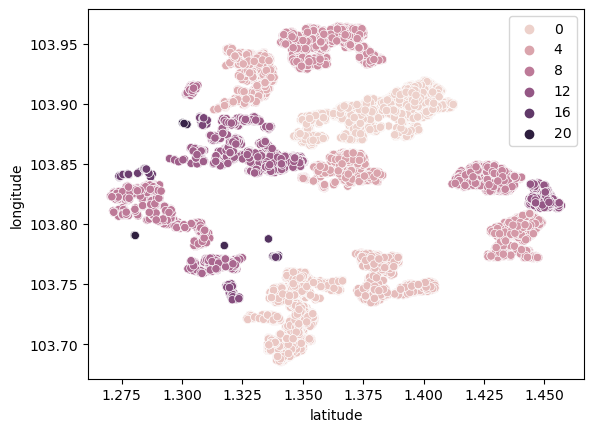

In [218]:
#add cluster feature
df_lat_long = df_train[['latitude', 'longitude']]
df_lat_long_test = df_test[['latitude', 'longitude']]
df_total = pd.concat([df_lat_long, df_lat_long_test], axis=0)
from sklearn.cluster import DBSCAN
DBSCAN_model = DBSCAN(eps=0.005, min_samples=1)
DBSCAN_model.fit(df_total)
#plot
sns.scatterplot(x='latitude', y='longitude', hue=DBSCAN_model.labels_, data=df_total)


In [219]:
df_train['cluster'] = DBSCAN_model.labels_[:len(df_train)]
df_test['cluster'] = DBSCAN_model.labels_[len(df_train):]

In [220]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,cluster
0,2021-01,sengkang,407b,fernvale road,5 room,premium apartment,110.0,yes,2005,1.388997,103.875148,0.0,fernvale,sengkang,north-east region,2100,0
1,2021-01,sengkang,313b,Anchorvale Road,5 room,premium apartment,110.0,yes,2003,1.391349,103.888012,0.0,anchorvale,sengkang,north-east region,2100,0
2,2021-01,jurong west,657a,Jurong West Street 65,4 room,model a,91.0,yes,2002,1.335413,103.700289,0.0,jurong west central,jurong west,west region,2150,1
3,2021-01,choa chu kang,484a,Choa Chu Kang Avenue 5,4 room,model a2,90.0,yes,1999,1.376685,103.736818,0.0,peng siang,choa chu kang,west region,2000,2
4,2021-01,jurong west,661c,Jurong West Street 64,5 room,improved,110.0,yes,2001,1.336077,103.705050,0.0,jurong west central,jurong west,west region,2950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59790,2023-07,jurong west,975,jurong west street 93,4-room,model a,105.0,yes,1989,1.340241,103.693550,0.0,yunnan,jurong west,west region,4000,1
59791,2023-07,yishun,331,Yishun Ring Road,4-room,model a,104.0,yes,1988,1.430613,103.843054,0.0,yishun east,yishun,north region,3350,7
59792,2023-07,queenstown,31,Ghim Moh Link,4-room,model a,93.0,yes,2018,1.309604,103.784023,0.0,ghim moh,queenstown,central region,4500,8
59793,2023-07,geylang,102,aljunied crescent,3-room,new generation,82.0,yes,1978,1.320481,103.882473,0.0,aljunied,geylang,central region,750,11


In [245]:
#feature engineering
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

df_train_, df_val_ = train_test_split(df_train, test_size=0.25, random_state=42)
df_train_processed = data_preprocess(df_train_, df_train_)
df_val_processed = data_preprocess(df_val_, df_train_)

df_train_processed

,floor_area_sqm,latitude,longitude,monthly_rent,coe_price,town_std,town_mean,town_median,street_name_std,street_name_mean,...,region_median,K=8 KNN_std,K=16 KNN_std,K=32 KNN_std,K=64 KNN_std,K=128 KNN_std,K=256 KNN_std,date_mean,date_std,date_median
47687,136.0,1.335865,103.853751,0.373030,92845.000,1.041792,-0.090967,-0.224675,1.068808,0.060363,...,0.133346,0.722650,0.690053,0.873094,0.921122,1.024279,0.983371,3055.199699,790.285151,3050.0
18495,144.0,1.436986,103.799118,0.906102,54951.625,0.934022,-0.180139,-0.209486,0.847397,-0.104802,...,-0.276633,0.949666,0.988249,0.873347,0.833705,0.805957,0.866285,2229.502688,408.891453,2200.0
16931,105.0,1.361550,103.962009,-0.316717,54951.625,0.870871,0.185406,0.112446,0.694596,0.232086,...,-0.088582,0.496606,0.641333,0.902049,0.931028,0.873335,0.838812,2229.502688,408.891453,2200.0
47215,67.0,1.316994,103.768507,-1.082141,92845.000,1.029823,0.116186,0.008518,0.869608,0.016752,...,-0.094791,0.795475,0.753676,0.815273,0.952670,0.934022,1.035165,3055.199699,790.285151,3050.0
4981,67.0,1.327974,103.937944,-0.698546,43812.000,0.944072,-0.252184,-0.316717,1.002560,-0.633688,...,-0.088582,0.619218,0.733911,0.705887,0.748865,0.791427,0.883910,2165.340909,379.847364,2100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,68.0,1.349272,103.743591,-1.273243,103440.750,0.949049,-0.256999,-0.294713,0.999214,-0.316305,...,-0.094791,0.934575,0.856977,0.989923,0.893117,0.867605,0.920023,3202.448276,787.319188,3150.0
38158,108.0,1.353027,103.882888,-1.017422,90883.875,0.904029,-0.149858,-0.213529,0.911534,0.373892,...,-0.107116,0.899203,0.778128,0.922120,0.977166,1.022061,0.953527,2759.991604,648.690407,2750.0
860,154.0,1.354293,103.937595,1.596483,45187.375,0.905499,0.092931,0.054690,0.619891,0.581644,...,-0.088582,0.597363,0.516213,0.695831,0.901755,0.915712,0.975586,2153.352865,373.726051,2100.0
15795,82.0,1.375495,103.839947,-1.564331,51997.375,0.907490,-0.307799,-0.370356,1.039632,-0.279376,...,-0.107116,0.652908,0.696797,0.738075,0.767117,0.886732,0.956935,2244.104235,411.744265,2200.0


In [249]:
features = df_train_processed.columns.tolist()
features.remove('monthly_rent')

features

['floor_area_sqm',
 'latitude',
 'longitude',
 'coe_price',
 'town_std',
 'town_mean',
 'town_median',
 'street_name_std',
 'street_name_mean',
 'street_name_median',
 'flat_type_std',
 'flat_type_mean',
 'flat_type_median',
 'flat_type2_std',
 'flat_type2_mean',
 'flat_type2_median',
 'cluster_std',
 'cluster_mean',
 'cluster_median',
 'block_std',
 'block_mean',
 'block_median',
 'lease_commence_date_std',
 'lease_commence_date_mean',
 'lease_commence_date_median',
 'flat_model_std',
 'flat_model_mean',
 'flat_model_median',
 'subzone_std',
 'subzone_mean',
 'subzone_median',
 'planning_area_std',
 'planning_area_mean',
 'planning_area_median',
 'region_std',
 'region_mean',
 'region_median',
 'K=8 KNN_std',
 'K=16 KNN_std',
 'K=32 KNN_std',
 'K=64 KNN_std',
 'K=128 KNN_std',
 'K=256 KNN_std',
 'date_mean',
 'date_std',
 'date_median']

In [250]:
df_norm = df_train.copy()
means = df_norm.groupby('rent_approval_date')['monthly_rent'].mean()
stds = df_norm.groupby('rent_approval_date')['monthly_rent'].std()

In [251]:
df_train_

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,cluster
47687,2023-01,toa payoh,45,Lorong 5 Toa Payoh,5-room,model a,136.0,yes,1993,1.335865,103.853751,0.0,boon teck,toa payoh,central region,3350,11
18495,2021-09,woodlands,656,woodlands ring road,executive,maisonette,144.0,yes,1998,1.436986,103.799118,0.0,woodlands east,woodlands,north region,2600,5
16931,2021-09,pasir ris,149,pasir ris street 13,4 room,model a,105.0,yes,1995,1.361550,103.962009,0.0,pasir ris drive,pasir ris,east region,2100,6
47215,2023-01,clementi,335,Clementi Avenue 2,3-room,new generation,67.0,yes,1978,1.316994,103.768507,0.0,clementi north,clementi,west region,2200,10
4981,2021-03,bedok,127,Bedok North Street 2,3 room,new generation,67.0,yes,1978,1.327974,103.937944,0.0,bedok north,bedok,east region,1900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,2023-05,bukit batok,148,Bukit Batok West Avenue 6,3-room,new generation,68.0,yes,1984,1.349272,103.743591,0.0,bukit batok west,bukit batok,west region,2200,1
38158,2022-08,hougang,142,Lorong Ah Soo,4-room,model a,108.0,yes,1984,1.353027,103.882888,0.0,lorong ah soo,hougang,north-east region,2100,0
860,2021-01,tampines,858,tampines avenue 5,executive,maisonette,154.0,yes,1988,1.354293,103.937595,0.0,tampines west,tampines,east region,2750,6
15795,2021-08,ang mo kio,156,Ang Mo Kio Avenue 4,3 room,new generation,82.0,yes,1981,1.375495,103.839947,0.0,kebun bahru,ang mo kio,north-east region,1600,4


In [252]:
X = df_train_processed[features]
y = df_train_['monthly_rent'].copy()
y -= means[df_train_['rent_approval_date']].values

In [253]:
y

47687     290.699708
18495     369.507290
16931    -130.492710
47215    -859.300292
4981     -261.546308
            ...     
54343    -984.357399
38158    -653.921569
860       607.395732
15795    -645.960591
56422   -1412.900724
Name: monthly_rent, Length: 44846, dtype: float64

In [255]:
from flaml import AutoML
automl = AutoML()

automl_settings = {
    "time_budget": 10,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['lgbm'],
    "eval_method": 'cv',
    "n_splits": 3,
}

automl.fit(X_train=X, y_train=y, **automl_settings)
y_pred = automl.predict(df_val_processed[features])
y_real = df_val_['monthly_rent']

basic_rmse = np.sqrt(mean_squared_error(y_real, y_pred))
print(basic_rmse)





[flaml.automl.logger: 10-25 15:47:58] {1679} INFO - task = regression
[flaml.automl.logger: 10-25 15:47:58] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-25 15:47:58] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-25 15:47:58] {1900} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 10-25 15:47:58] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-25 15:47:59] {2344} INFO - Estimated sufficient time budget=3190s. Estimated necessary time budget=3s.
[flaml.automl.logger: 10-25 15:47:59] {2391} INFO -  at 0.6s,	estimator lgbm's best error=547.6652,	best estimator lgbm's best error=547.6652
[flaml.automl.logger: 10-25 15:47:59] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-25 15:47:59] {2391} INFO -  at 0.9s,	estimator lgbm's best error=547.6652,	best estimator lgbm's best error=547.6652
[flaml.automl.logger: 10-25 15:47:59] {2218} INFO - iteration 2, current learner lgbm
[flaml.a

In [259]:
features = X.columns.tolist()
feature_importance = pd.DataFrame({'feature': features, 'importance': automl.model.estimator.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance

ValueError: All arrays must be of the same length

In [258]:

best_score = 1000
best_features = features.copy()
features_tmp = features.copy()
cnt = 0
while len(features_tmp) > 1:

    best_score2 = 1000
    best_features2 = features_tmp.copy()
    for feature in features_tmp:
        features_tmp2 = features_tmp.copy()
        features_tmp2.remove(feature)
        
        automl = AutoML()
        automl.fit(X_train=X[features_tmp2], y_train=y, **automl_settings)

        y_pred = automl.predict(df_val_processed[features_tmp2])
        y_pred += means[df_val_['rent_approval_date']].values
        y_real = df_val_['monthly_rent']

        rmse = np.sqrt(mean_squared_error(y_real, y_pred))
        print("now rmse: ", rmse, "best rmse: ", best_score2)
        if rmse < best_score2:
            best_score2 = rmse
            best_features2 = features_tmp2.copy()
    if best_score2 < best_score:
        best_score = best_score2
        best_features = best_features2.copy()
    else:
        cnt += 1
    features_tmp = best_features2.copy()

    if cnt > 3:
        break
    

print(best_score)
print(best_features)

    


[flaml.automl.logger: 10-25 15:49:04] {1679} INFO - task = regression
[flaml.automl.logger: 10-25 15:49:04] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-25 15:49:04] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-25 15:49:04] {1900} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 10-25 15:49:04] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-25 15:49:05] {2344} INFO - Estimated sufficient time budget=3099s. Estimated necessary time budget=3s.
[flaml.automl.logger: 10-25 15:49:05] {2391} INFO -  at 0.6s,	estimator lgbm's best error=547.6652,	best estimator lgbm's best error=547.6652
[flaml.automl.logger: 10-25 15:49:05] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-25 15:49:05] {2391} INFO -  at 0.9s,	estimator lgbm's best error=547.6652,	best estimator lgbm's best error=547.6652
[flaml.automl.logger: 10-25 15:49:05] {2218} INFO - iteration 2, current learner lgbm
[flaml.a

In [260]:
set(features) - set(best_features)

{'K=128 KNN_std',
 'K=256 KNN_std',
 'K=8 KNN_std',
 'block_mean',
 'block_median',
 'cluster_std',
 'coe_price',
 'lease_commence_date_mean',
 'town_mean'}

In [275]:
#remove

{'K=128 KNN_std',
 'K=256 KNN_std',
 'K=8 KNN_std',
 'block_mean',
 'block_median',
 'cluster_std',
 'coe_price',
 'lease_commence_date_mean',
 'town_mean'}



{'K=128 KNN_std',
 'K=256 KNN_std',
 'K=8 KNN_std',
 'block_mean',
 'block_median',
 'cluster_std',
 'coe_price',
 'lease_commence_date_mean',
 'town_mean'}

In [261]:
best_features

['floor_area_sqm',
 'latitude',
 'longitude',
 'town_std',
 'town_median',
 'street_name_std',
 'street_name_mean',
 'street_name_median',
 'flat_type_std',
 'flat_type_mean',
 'flat_type_median',
 'flat_type2_std',
 'flat_type2_mean',
 'flat_type2_median',
 'cluster_mean',
 'cluster_median',
 'block_std',
 'lease_commence_date_std',
 'lease_commence_date_median',
 'flat_model_std',
 'flat_model_mean',
 'flat_model_median',
 'subzone_std',
 'subzone_mean',
 'subzone_median',
 'planning_area_std',
 'planning_area_mean',
 'planning_area_median',
 'region_std',
 'region_mean',
 'region_median',
 'K=16 KNN_std',
 'K=32 KNN_std',
 'K=64 KNN_std',
 'date_mean',
 'date_std',
 'date_median']

In [ ]:
#best features
['floor_area_sqm',
 'latitude',
 'longitude',
 'town_std',
 'town_median',
 'street_name_std',
 'street_name_mean',
 'street_name_median',
 'flat_type_std',
 'flat_type_mean',
 'flat_type_median',
 'flat_type2_std',
 'flat_type2_mean',
 'flat_type2_median',
 'cluster_mean',
 'cluster_median',
 'block_std',
 'lease_commence_date_std',
 'lease_commence_date_median',
 'flat_model_std',
 'flat_model_mean',
 'flat_model_median',
 'subzone_std',
 'subzone_mean',
 'subzone_median',
 'planning_area_std',
 'planning_area_mean',
 'planning_area_median',
 'region_std',
 'region_mean',
 'region_median',
 'K=16 KNN_std',
 'K=32 KNN_std',
 'K=64 KNN_std',
 'date_mean',
 'date_std',
 'date_median']

In [262]:
ds_train_processed = data_preprocess(df_train, df_train)
ds_test_processed = data_preprocess(df_test, df_train)
ds_train_processed

,floor_area_sqm,latitude,longitude,monthly_rent,coe_price,town_std,town_mean,town_median,street_name_std,street_name_mean,...,region_median,K=8 KNN_std,K=16 KNN_std,K=32 KNN_std,K=64 KNN_std,K=128 KNN_std,K=256 KNN_std,date_mean,date_std,date_median
0,110.0,1.388997,103.875148,-0.116219,45187.375,0.852063,0.051473,0.000101,0.822048,-0.120922,...,-0.116219,0.552914,0.576671,0.724513,0.739432,0.720515,0.859754,2142.604268,366.587073,2100.0
1,110.0,1.391349,103.888012,-0.116219,45187.375,0.852063,0.051473,0.000101,0.916739,-0.002345,...,-0.116219,0.555564,0.747911,0.863253,0.820683,0.788476,0.810921,2142.604268,366.587073,2100.0
2,91.0,1.335413,103.700289,0.020175,45187.375,0.996782,0.106384,0.102656,0.903958,0.465284,...,-0.090385,0.800094,1.077009,0.964903,0.896131,0.876252,0.868063,2142.604268,366.587073,2100.0
3,90.0,1.376685,103.736818,-0.389005,45187.375,0.898640,-0.144284,-0.208365,0.943755,0.021383,...,-0.090385,0.570958,0.649760,0.744889,0.784018,0.830630,0.870558,2142.604268,366.587073,2100.0
4,110.0,1.336077,103.705050,2.202466,45187.375,0.996782,0.106384,0.102656,0.903494,0.619331,...,-0.090385,0.768997,0.718599,0.702743,0.834438,0.826835,0.843519,2142.604268,366.587073,2100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59790,105.0,1.340241,103.693550,0.925308,104442.375,0.996782,0.106384,0.102656,1.023925,0.283341,...,-0.090385,0.835411,0.900919,0.939026,1.065622,0.940717,0.877891,3256.823760,803.166361,3250.0
59791,104.0,1.430613,103.843054,0.116011,104442.375,0.899249,-0.345850,-0.386738,0.888215,-0.428102,...,-0.292951,0.654588,0.724437,0.769427,0.819457,0.909829,0.938559,3256.823760,803.166361,3250.0
59792,93.0,1.309604,103.784023,1.547844,104442.375,1.241351,0.443363,0.348288,1.503976,1.018424,...,0.146141,0.492026,1.013883,0.917894,1.121017,1.162651,1.146640,3256.823760,803.166361,3250.0
59793,82.0,1.320481,103.882473,-3.121176,104442.375,1.064736,-0.190295,-0.279559,0.793451,-0.484442,...,0.146141,0.836869,1.162607,1.089344,0.889005,0.883303,0.900100,3256.823760,803.166361,3250.0


In [263]:
# attributes = ds_train_processed.keys()[ds_train_processed.keys() != 'rent_approval_date']
# grouped = ds_train_processed.groupby('rent_approval_date')
# for attribute in attributes:
#     ds_train_processed = grouped.apply(handle_outliers, attribute=attribute)

In [264]:
ds_train_processed.describe()

,floor_area_sqm,latitude,longitude,monthly_rent,coe_price,town_std,town_mean,town_median,street_name_std,street_name_mean,...,region_median,K=8 KNN_std,K=16 KNN_std,K=32 KNN_std,K=64 KNN_std,K=128 KNN_std,K=256 KNN_std,date_mean,date_std,date_median
count,59795.000000,59795.000000,59795.000000,5.979500e+04,59795.000000,59795.000000,5.979500e+04,59795.000000,59790.000000,5.979500e+04,...,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000,59795.000000
mean,94.422686,1.359627,103.840182,1.930984e-17,75185.622197,0.963791,1.699266e-17,-0.058595,0.889078,1.806213e-17,...,-0.068093,0.712917,0.779240,0.826690,0.862893,0.892534,0.911284,2584.139142,564.773729,2550.061042
std,24.075897,0.042422,0.071683,9.997491e-01,21312.333087,0.095152,2.489149e-01,0.246872,0.126985,4.555203e-01,...,0.133859,0.228831,0.182950,0.149540,0.127839,0.112822,0.101600,389.376818,166.114930,409.877526
min,34.000000,1.270380,103.685228,-4.577843e+00,43812.000000,0.852063,-3.458497e-01,-0.386738,0.054885,-1.938144e+00,...,-0.292951,0.120642,0.265654,0.426418,0.481109,0.628708,0.658615,2142.604268,366.587073,2100.000000
25%,73.000000,1.331122,103.778700,-7.158524e-01,52199.625000,0.898914,-1.980409e-01,-0.245034,0.814611,-3.078370e-01,...,-0.116219,0.549699,0.654478,0.724833,0.775173,0.814980,0.841877,2244.716619,409.331849,2200.000000
50%,93.000000,1.354222,103.845493,-7.932483e-02,77035.625000,0.935145,1.223405e-02,-0.063464,0.875549,-6.449330e-02,...,-0.090385,0.690913,0.762352,0.812298,0.848954,0.878301,0.897925,2432.078749,528.611405,2400.000000
75%,110.000000,1.387045,103.897547,6.510527e-01,96230.250000,1.024774,1.063841e-01,0.084141,0.958320,2.326726e-01,...,-0.085924,0.852392,0.887278,0.914106,0.936564,0.955247,0.965379,3059.300292,778.595583,3050.000000
max,192.000000,1.457071,103.964915,3.090164e+00,105592.375000,1.241351,7.477542e-01,0.614542,1.990688,2.265644e+00,...,0.146141,1.775046,1.635501,1.563811,1.576526,1.528629,1.455394,3256.823760,803.166361,3250.000000


In [265]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [266]:
df_norm = df_train.copy()
#df_norm['monthly_rent'] = np.log(df_norm['monthly_rent'])
means = df_norm.groupby('rent_approval_date')['monthly_rent'].mean()
stds = df_norm.groupby('rent_approval_date')['monthly_rent'].std()

In [267]:
X = ds_train_processed.drop(['monthly_rent'], axis=1)
#X.drop(['rent_approval_date'], axis=1, inplace=True)
y = df_train['monthly_rent']# - means[df_train['rent_approval_date']].reset_index(drop=True)
X = X[best_features]



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#real_X_train, real_X_test, real_y_train, real_y_test = train_test_split(df_train, real_y, test_size=0.3, random_state=42)





In [268]:
#tuning with FLAML
from flaml import AutoML

automl = AutoML()
automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "eval_method": 'cv',
    "n_splits": 4,
    "estimator_list": ['lgbm', 'xgboost', 'xgb_limitdepth'],
    #"estimator_list": ['kneighbor'],
}

automl.fit(X_train=X, y_train=y, **automl_settings)

[flaml.automl.logger: 10-25 17:10:20] {1679} INFO - task = regression
[flaml.automl.logger: 10-25 17:10:20] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-25 17:10:20] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-25 17:10:20] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth']
[flaml.automl.logger: 10-25 17:10:20] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-25 17:10:21] {2344} INFO - Estimated sufficient time budget=5020s. Estimated necessary time budget=33s.
[flaml.automl.logger: 10-25 17:10:21] {2391} INFO -  at 0.8s,	estimator lgbm's best error=623.4856,	best estimator lgbm's best error=623.4856
[flaml.automl.logger: 10-25 17:10:21] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-25 17:10:21] {2391} INFO -  at 1.3s,	estimator lgbm's best error=623.4856,	best estimator lgbm's best error=623.4856
[flaml.automl.logger: 10-25 17:10:21] {2218} INFO - iteration 2,

In [269]:
features = X.columns.tolist()
feature_importance = pd.DataFrame({'feature': features, 'importance': automl.model.estimator.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance

,feature,importance
8,flat_type_std,0.138556
11,flat_type2_std,0.129797
36,date_median,0.109356
9,flat_type_mean,0.086816
34,date_mean,0.079200
12,flat_type2_mean,0.055024
35,date_std,0.054806
13,flat_type2_median,0.047591
10,flat_type_median,0.038668
6,street_name_mean,0.034893


In [270]:
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
print('Best estimator:', automl.best_estimator)

Best hyperparmeter config: {'n_estimators': 986, 'max_leaves': 7, 'min_child_weight': 128.0, 'learning_rate': 0.055930937967793484, 'subsample': 0.8172494025787316, 'colsample_bylevel': 0.4691579790429071, 'colsample_bytree': 0.6363041934135629, 'reg_alpha': 0.0044372497585360125, 'reg_lambda': 0.2783194991561815}
Best r2 on validation data: -474.4
Training duration of best run: 7.524 s
Best estimator: xgboost


In [271]:
#479
#xgboost
#'n_estimators': 9151, 'max_depth': 10, 'min_child_weight': 63.557633406056944, 'learning_rate': 0.000979816325814351, 'subsample': 1.0, 'colsample_bylevel': 0.43723796957664957, 'colsample_bytree': 0.45210514155071946, 'reg_alpha': 0.0018026364258123973, 'reg_lambda': 0.9378754948097449

In [272]:
#submit with FLAML
df_test['monthly_rent'] = 0

ds_test_processed = data_preprocess(df_test, df_train)
ds_test_processed.drop(['monthly_rent'], axis=1, inplace=True)
ds_test_processed = ds_test_processed[best_features]
#ds_test_processed.drop(['rent_approval_date'], axis=1, inplace=True)
y_pred = automl.predict(ds_test_processed)
y_pred = y_pred# + means[df_test['rent_approval_date']].reset_index(drop=True)

#y_pred.reset_index(drop=True, inplace=True)
submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = y_pred
submission.to_csv('submission.csv', index=False)

In [273]:
submission

,Id,Predicted
0,0,2859.880127
1,1,2740.281006
2,2,3500.247803
3,3,2037.126221
4,4,2526.147217
...,...,...
29995,29995,2829.736084
29996,29996,2809.342285
29997,29997,2751.212891
29998,29998,3361.160400


In [174]:
#plot distribution from predcit and real
plt.figure(figsize=(20, 10))
sns.distplot(real_y_test, hist=False, label='y_val')
sns.distplot(y_pred, hist=False, label='y_pred')
plt.legend()
plt.show()

NameError: name 'real_y_test' is not defined

<Figure size 2000x1000 with 0 Axes>